## Data processing for multiclass (ML50-2023)

### __Importing libraries__

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from IPython.display import display_html
from IPython.display import display, HTML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score

### __Importing data__

In [125]:
# Data path : ../Data/test.csv
test_path = os.path.join('..', 'Data', 'test.csv')
train_path = os.path.join('..', 'Data', 'train.csv')

# Read data
test = pd.read_csv(test_path, index_col='encounter_id')
train = pd.read_csv(train_path, index_col='encounter_id')

# Since we are going to do work with just the categorical readmitted variable, lets drop the binary one 
train.drop('readmitted_binary', axis=1, inplace=True)

# Keep track of the ids of the test and training data
test_ids = test.index
train_ids = train.index

# Data will have to be treated as a whole, so we will concatenate the test and training data
data = pd.concat([train, test], axis=0)

### __Minor changes to the data__
- __Remove 0 variance columns__
- __Changing column names__
- __Binary encoding__
- __?, Not Mapped, Not Available as NaN__
- __Applying the changes to the test and train data__

__1. Removing 0 variance columns__

In [126]:
data = data.drop(['country'], axis=1)

__2. Changing column names__

In [127]:
mapper = {
    'outpatient_visits_in_previous_year': 'n_outvis',
    'inpatient_visits_in_previous_year': 'n_invis',
    'emergency_visits_in_previous_year': 'n_emvis',
    'change_in_meds_during_hospitalization': 'b_changeMeds',
    'prescribed_diabetes_meds': 'b_diabetesMeds',
    'length_of_stay_in_hospital': 'n_stay',
    'number_of_medications': 'n_meds',
    'primary_diagnosis': 'c_diag1',
    'secondary_diagnosis': 'c_diag2',
    'additional_diagnosis': 'c_diag3',
    'number_diagnoses': 'n_diag',
    'number_lab_tests': 'n_tests',
    'discharge_disposition': 'c_disp',
    'race' : 'c_race',
    'gender' : 'b_gender',
    'age' : 'c_age',
    'weight' : 'c_weight',
    'admission_type' : 'c_admission',
    'payer_code' : 'c_payer',
    'medical_specialty' : 'c_specialty',
    'glucose_test_result' : 'c_glu',
    'a1c_test_result' : 'c_a1c',
    'average_pulse_bpm' : 'n_pulse',
    'readmitted_multiclass' : 'c_target',
    'medication' : 'c_medication',
    'admission_source' : 'c_source',
    'non_lab_procedures' : 'n_nonLab',
    'patient_id' : 'c_patient',
}

data = data.rename(columns=mapper)
data.columns

Index(['c_patient', 'c_race', 'b_gender', 'c_age', 'c_weight', 'c_payer',
       'n_outvis', 'n_emvis', 'n_invis', 'c_admission', 'c_specialty',
       'n_pulse', 'c_disp', 'c_source', 'n_stay', 'n_tests', 'n_nonLab',
       'n_meds', 'c_diag1', 'c_diag2', 'c_diag3', 'n_diag', 'c_glu', 'c_a1c',
       'b_changeMeds', 'b_diabetesMeds', 'c_medication', 'c_target'],
      dtype='object')

__3. Binary encoding__

In [128]:
binary_features = [col for col in data.columns if col.startswith('b_')]
data['b_gender'] = data['b_gender'].map({'Female' : 0, 'Male' : 1})
data['b_changeMeds'] = data['b_changeMeds'].map({'No' : 0, 'Ch' : 1})
data['b_diabetesMeds'] = data['b_diabetesMeds'].map({'No' : 0, 'Yes' : 1})

data[binary_features]

,b_gender,b_changeMeds,b_diabetesMeds
encounter_id,,,
533253,0.0,0,0
426224,1.0,0,1
634063,0.0,1,1
890610,1.0,0,0
654194,0.0,0,0
...,...,...,...
451150,1.0,0,0
549298,1.0,0,1
327586,0.0,0,1


__4. ?, Not Mapped, Not Available as NaN__

In [129]:
to_replace = ['?', 'Not Mapped', 'Not Available', ' Not Mapped']
data = data.replace(to_replace, np.nan)

__5. Applying the changes to the test and train data__

In [130]:
train = data.loc[train_ids]
test = data.loc[test_ids]

### __Changes in data__

In [358]:
def var_report(column_name, data=data, train_ids=train_ids, test_ids=test_ids, exclude_graphs=False, hide_low_freq=False, count_threshold=100, order_by_count=False):
    train_ids = [idx for idx in train_ids if idx in data.index]
    test_ids = [idx for idx in test_ids if idx in data.index]
    train = data.loc[train_ids].copy()
    test = data.loc[test_ids].copy()

    # For the missing values
    train_missing = train[column_name].isna().sum()
    test_missing = test[column_name].isna().sum()
    train_missing_pct = round(100*train_missing/len(train[column_name]), 2)
    test_missing_pct = round(100*test_missing/len(test[column_name]), 2)
    train_missing_str = "{} ({:.2f}%)".format(train_missing, train_missing_pct)
    test_missing_str = "{} ({:.2f}%)".format(test_missing, test_missing_pct)

    # Filling the nans as missing so that we dont get errors in crosstab and its more beautiful
    train[column_name] = train[column_name].fillna("MISSING")
    test[column_name] = test[column_name].fillna("MISSING")

    train_counts = train[column_name].value_counts()
    test_counts = test[column_name].value_counts()

    # Hide the low frequency values as 'Other'
    if hide_low_freq:
        # Which values have a count lower than the threshold
        low_freq_values = train_counts[train_counts <= count_threshold].index
        low_freq_values_test = test_counts[test_counts <= count_threshold].index
        # Replace them with 'Other'
        train[column_name] = train[column_name].replace(low_freq_values, 'Low Frequency')
        test[column_name] = test[column_name].replace(list(low_freq_values)+list(low_freq_values_test), 'Low Frequency')
        
        # Recalculate the counts
        train_counts = train[column_name].value_counts()
        test_counts = test[column_name].value_counts()

    train_counts_pct = round(100*train_counts / len(train[column_name]), 2)
    test_counts_pct = round(100*test_counts / len(test[column_name]), 2)

    # Change the names of the counts
    train_counts = train_counts.rename('Counts')
    test_counts = test_counts.rename('Counts')
    train_counts_pct = train_counts_pct.rename('Percentage')
    test_counts_pct = test_counts_pct.rename('Percentage')

    # Test counts already ready to be displayed
    test_counts = pd.concat([test_counts, test_counts_pct], axis=1)

    # Calculate the percentage of each category in the target
    percentage_to_target = round(pd.crosstab(train[column_name], train['c_target'], normalize='index')*100,2)

    # Add the counts to the percentage_to_target
    train_counts = pd.concat([train_counts, train_counts_pct, percentage_to_target], axis=1)

    # Calculate the global mean for each category in 'c_target'
    global_mean = 100 * data['c_target'].value_counts(normalize=True)
    
    anomaly = pd.DataFrame()
    # Calculate the anomaly for each category in 'c_target'
    for category in ['<30 days', '>30 days', 'No']:
        anomaly[category + ' anomaly'] = round(((train_counts[category] - global_mean[category]) / global_mean[category]) * 100,2)

    # Sort annomaly values by the max
    if not order_by_count:
        anomaly = anomaly.reindex((anomaly.max(axis=1)).sort_values(ascending=False).index)
    
    else: 
        anomaly.sort_index(inplace=True)


    # Add styling to the anomaly dataframe
    anomaly['Count'] = train_counts['Counts']

    anomaly_ = anomaly.style.background_gradient(cmap='coolwarm', axis=0).format("{:.0f}")
    anomaly_html = anomaly_.to_html()

    # Generate the html tables
    test_counts = test_counts.style.background_gradient(cmap='coolwarm', axis=0).format("{:.2f}")
    train_counts_html = train_counts.to_html()
    test_counts_html = test_counts.to_html()

    if not exclude_graphs:
        # Plotting the data
        fig, ax = plt.subplots(1,3, figsize=(20,5))

        percentage_to_target.sort_values(by='No', ascending=False).plot.bar(ax=ax[0])
        ax[0].set_title('Distribution of the target')
        ax[0].set_ylabel('Percentage')

        # Plotting the distribution of the variable itself for train and test in the same plot but with two bars for each value
        train_counts_pct.plot.bar(ax=ax[1], width=0.2, position=0, label='Train', color='orange')
        test_counts_pct.plot.bar(ax=ax[1], width=0.2, position=1, label='Test', color='blue')
        ax[1].set_title('Distribution of the variable')
        ax[1].set_ylabel('Percentage')
        ax[1].legend()

        # Plot the annomalies
        anomaly.drop('Count', axis=1).plot.bar(ax=ax[2])
        ax[2].set_title('Anomaly')
        ax[2].set_ylabel('Percentage')

    # Displaying the tables 
    display(HTML(f"""
        <div style="display: flex; justify-content: space-between;">
            <div style="padding-right: 20px;">
                <h3>Value counts in train data:</h3>
                {train_counts_html}
            </div> 
            
            <div style="padding-right: 20px;">
                <h3>Anomaly:</h3>
                {anomaly_html}
            </div>

            <div style="padding-right: 20px;">
                <h3>Value counts in test data:</h3>
                {test_counts_html}
            </div>

            <div>
                <h3>Missing values in train data:</h3>
                {train_missing_str}
                <h3>Missing values in test data:</h3>
                {test_missing_str}
            </div>
        </div>
    """))

# One hot encoding, avoid dummy trap
def one_hot_encode(data, column_name, drop_first=False):
    # Set dummy na to true so that we get a column for the missing values
    if data[column_name].isna().sum() > 0:
        data[column_name] = data[column_name].fillna('missing')
    dummies = pd.get_dummies(data[column_name], prefix=column_name, drop_first=drop_first, dtype=np.int8)
    # Change the names of the dummies so that they start with b_ instead of c_
    dummies.columns = ['b_' + col[2:] for col in dummies.columns]
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column_name, axis=1)
    return data

- What we want to be able to predict is the lower count classes, namely the <30days and the >30days anomaly, as the larger class will almost surely be the easiest to guess. Thus, we want to get the categories that have high anomalies. 
- Actually, we just want high anomalies, which means a large amount of information in the given variable. 
- A very high anomaly in the 'No' category is also important, as it will almost surely point to a 'No' answer, and so on.

#### __1. Race__
__Modifications:__
- Nothing yet, because `we are going to fill the missing values with an imputer`, but we dont want to keep african american, asian and other. 
<br>

__Relevant Information:__
- African american has no information at all.
- Missing race is also not very useful, as it has a low anomaly for the No category, so it doesn't give much information about that and it doesn't give any information about the Yes categories.
- Caucasian slightly relevant, because it increases the yes categories, but not very much.
- Asian very low count to mean anything (0.61%)
- Other is also very low count (1.43%)
__________________________________________

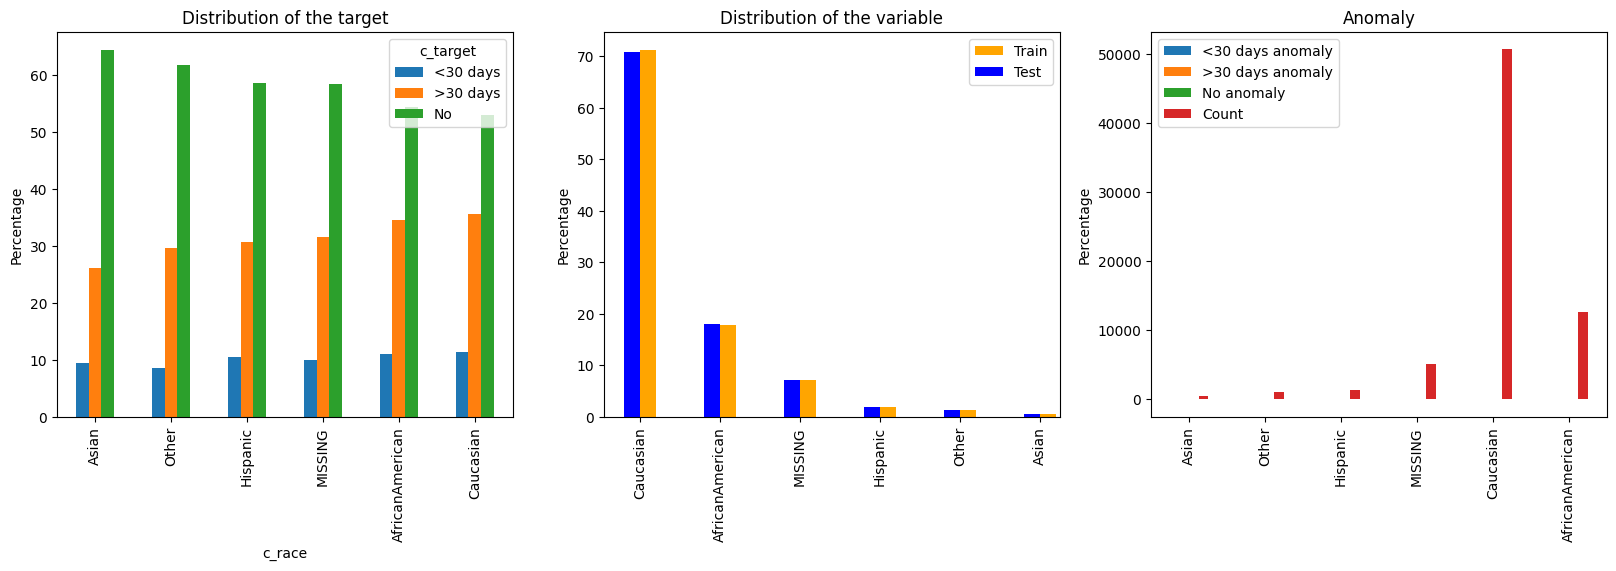

In [208]:
var_report('c_race', data)

In [112]:
data = one_hot_encode(data, 'c_race').drop(['b_race_missing', 'b_race_Other', 'b_race_Hispanic'], axis=1)

#### __2. Gender__
__Modifications:__
- Droping the NaN values (<0.01%)
<br>

__Relevant Information:__
- Very slight information for gender. 
__________________________________________

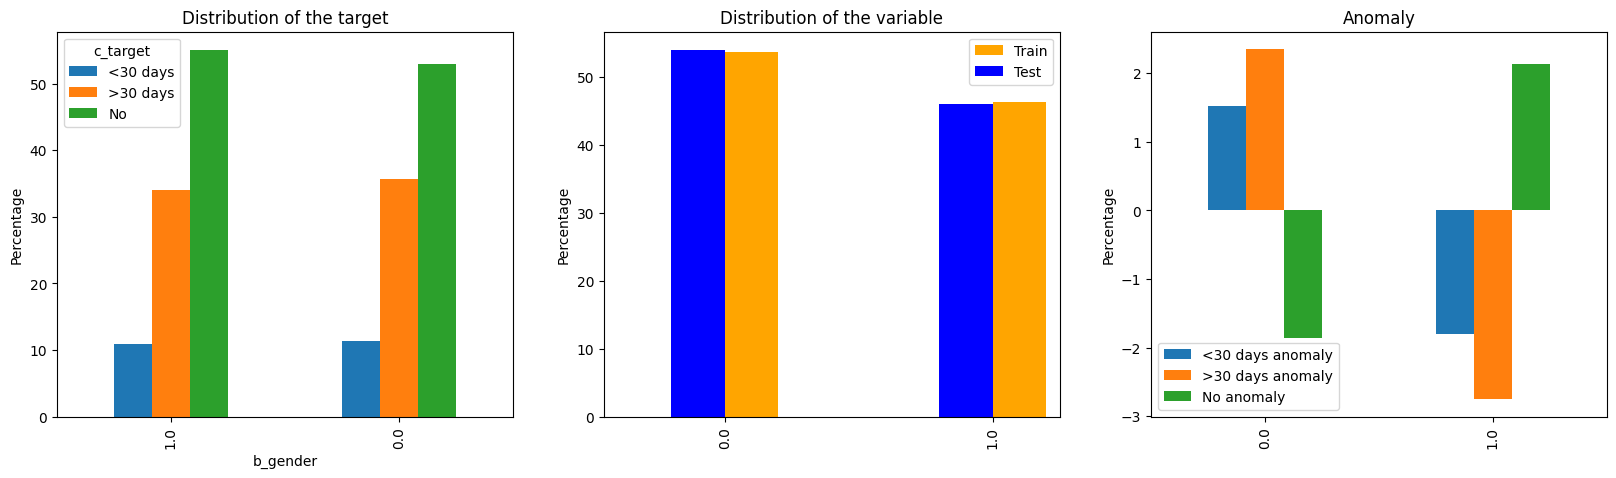

In [161]:
var_report('b_gender', data)

In [162]:
# Drop variables in train with a Nan gender
ids_to_drop = data[data.isna()['b_gender']].index
train = train.drop(ids_to_drop)
data = data[~data.isna()['b_gender']]

#### __3. Age__
__Modifications:__
- Considering the middle point of the age range
<br>

__Relevant Information:__
- Great information for the <30 days category in the `20-30`, `80-90` ranges.
- Not very useful for the >30 days category.
- Joint information for low count categories in the `70-80` range, with high count. 
- Almost no information for the No category. In the 0-10, 10-20 and 90-100 we have a little bit of information but unsatisfactory counts.
__________________________________________

,Counts,Percentage,<30 days,>30 days,No
[70-80),17357,24.37,11.76,36.34,51.90
[60-70),14907,20.93,10.88,35.00,54.12
[80-90),11510,16.16,12.28,36.46,51.26
[50-60),11423,16.04,9.90,34.36,55.74
[40-50),6418,9.01,10.49,33.28,56.23
MISSING,3557,4.99,10.99,35.28,53.73
[30-40),2536,3.56,10.88,31.55,57.57
[90-100),1875,2.63,11.73,28.91,59.36
[20-30),1071,1.50,14.19,30.53,55.28
[10-20),474,0.67,6.12,32.49,61.39


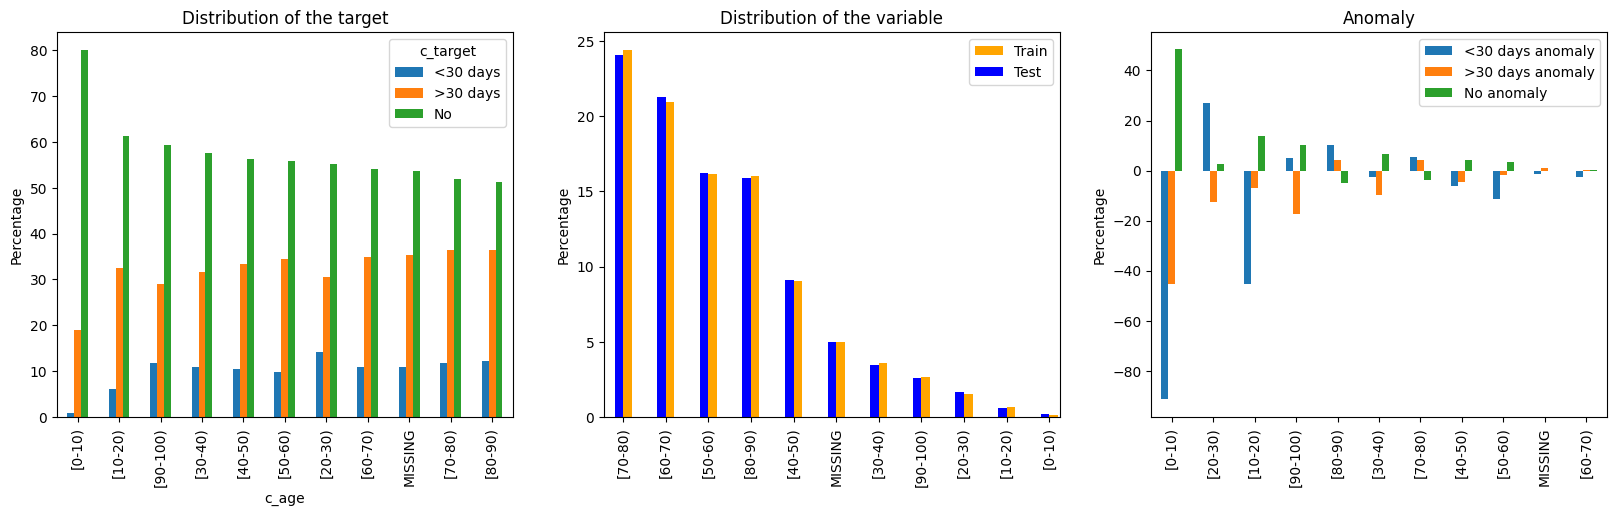

In [163]:
var_report('c_age', data)

In [164]:
age_dict = {'[0-10)': 5,
           '[10-20)': 15,
           '[20-30)': 25,
           '[30-40)': 35,
           '[40-50)': 45,
           '[50-60)': 55,
           '[60-70)': 65,
           '[70-80)': 75,
           '[80-90)': 85,
           '[90-100)': 95}

data.loc[:, 'n_age'] = data['c_age'].map(age_dict)
data = data.drop('c_age', axis=1)

#### __4. Weight__
__Modifications:__
- Joining `50-75` and `75-100` weights to keep the `50-100` range binary variable, and we will also keep the missing 
<br>

__Relevant Information:__
- A lot of information for the >30days anomaly in the `75-100` range, without a terrible count (1.32%). Some information on the `50-75` range, but not very much.
- Missing information has a slight amount of information for >30 days, so it maybe worth keeping it.
__________________________________________

In [ ]:
var_report('c_weight', data)

In [173]:
data['b_weight'] = data['c_weight'].notna().astype(np.int8)
data['b_weight_50_100'] = data['c_weight'].apply(lambda x: 1 if x in ['[50-75)', '[75-100)'] else 0).astype(np.int8)
data = data.drop('c_weight', axis=1)

#### __5. Payer code__
__Modifications:__
- Deleting FR because not present in the test data. Deleting CM, OG, WC, CH, MP, OT, SI, DM
- One hot encoding
<br>

__Relevant Information:__
- For the <30 days anomaly: `MD`, `MC`, `Missing` have lots of information and an excelent count
- For the >30 days anomaly: `MP`, `HM`, `SP`, `MC` are informative.
- For the anomaly, `BC`, `UN`, `CP`, `PO` are important.
__________________________________________

,Counts,Percentage,<30 days,>30 days,No
MISSING,28200,39.59,11.52,34.45,54.03
MC,22683,31.84,11.89,36.80,51.31
HM,4319,6.06,9.79,36.56,53.65
SP,3541,4.97,10.05,37.81,52.13
BC,3292,4.62,9.39,27.64,62.97
MD,2484,3.49,12.52,35.47,52.01
CP,1760,2.47,8.98,30.63,60.40
UN,1733,2.43,8.60,30.06,61.34
CM,1347,1.89,8.83,34.60,56.57
OG,729,1.02,11.52,31.69,56.79


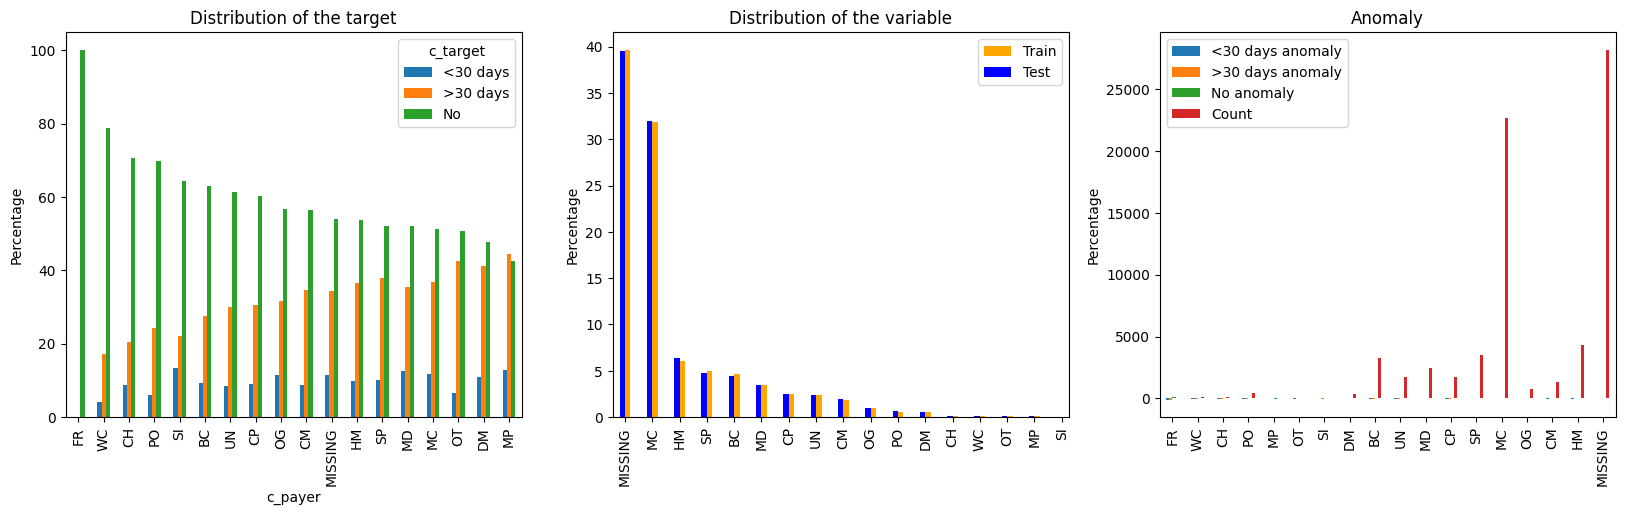

In [185]:
var_report('c_payer', data)

In [193]:
# One hot encode the payer group
payers_to_drop = ['CM', 'OG', 'WC', 'CH', 'MP', 'OT', 'SI', 'DM', 'FR']
payers_to_drop = ['b_payer_' + payer for payer in payers_to_drop]
data = one_hot_encode(data, 'c_payer').drop(payers_to_drop, axis=1)

#### __6. Out-/Em-/Invisits__
__Modifications:__
- Croping the outliers and grouping them in a specific bin (4,5,3), changing the threshold based on the variable in question
- Creating a n_visits column with the sum of the 3 variables, and n_visits_pure with the sum of the unclipped variables (both clipped to last bin = 7).
<br>

__Relevant Information:__
- Outvisits less relevant showing a harmonic relationship with <30 days anomaly. Monothonic relationship with >30 days anomaly, though.
- Great linear relationship overall with the anomaly.
__________________________________________

##### __6.0 Pure visits__
__Last bin = 7__
- Good monotonic relationship 

,Counts,Percentage,<30 days,>30 days,No
0,38986,54.73,8.13,27.96,63.91
1,14031,19.70,11.39,39.13,49.48
2,7072,9.93,14.95,43.38,41.67
3,4109,5.77,15.55,46.85,37.60
4,2490,3.50,17.43,47.91,34.66
5,1418,1.99,17.91,49.86,32.23
6,920,1.29,22.83,50.00,27.17
7,629,0.88,23.69,51.19,25.12
Low Frequency,426,0.60,30.75,53.05,16.20
8,397,0.56,25.19,50.63,24.18


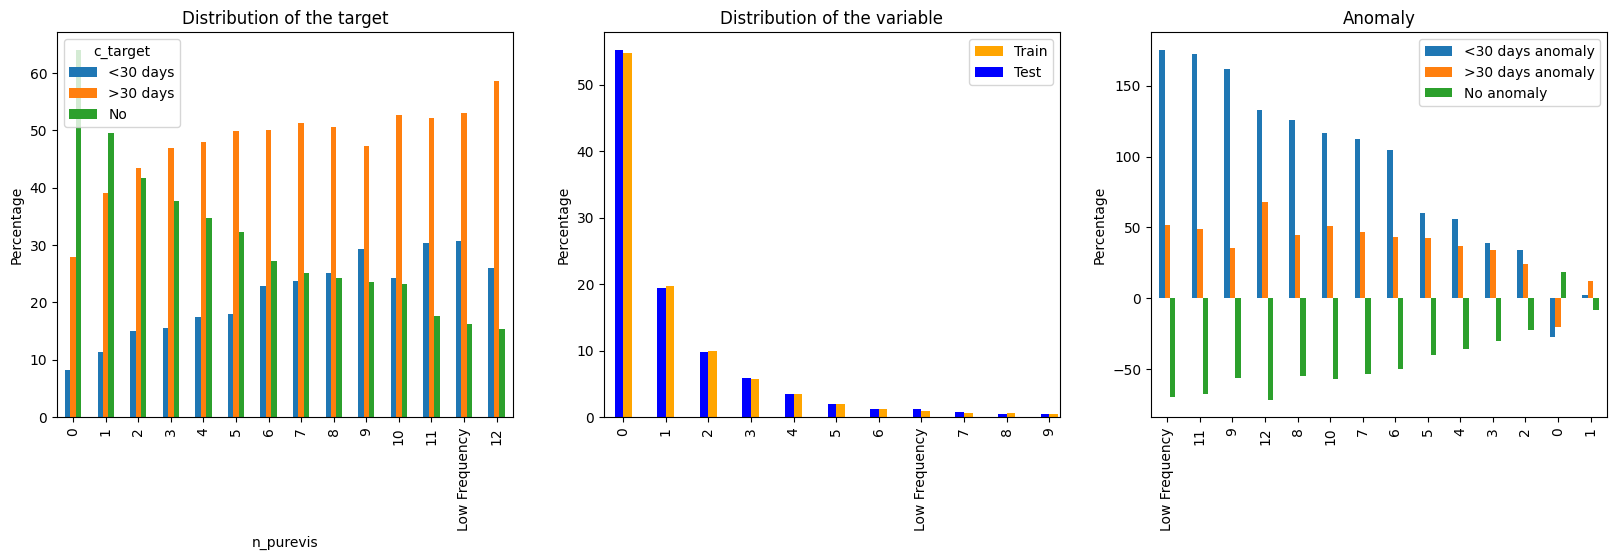

In [216]:
data['n_purevis'] = data['n_outvis'] + data['n_invis'] + data['n_emvis']
var_report('n_purevis', data, hide_low_freq=True)

In [217]:
data['n_purevis'] = data['n_purevis'].clip(upper=7)
data.value_counts('n_purevis')

n_purevis
0    55825
1    19941
2    10062
3     5904
4     3570
7     3112
5     2036
6     1313
dtype: int64

##### __6.1 Outvisits__
__Last bin = 4__

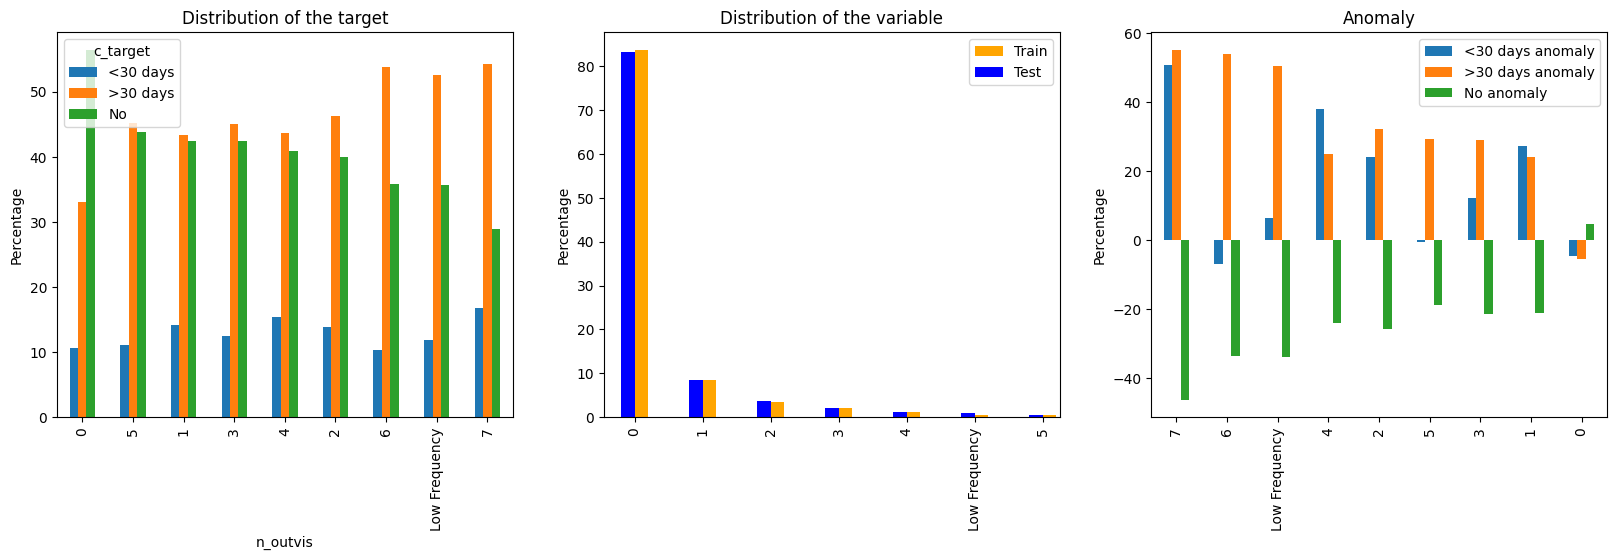

In [219]:
var_report('n_outvis', data, hide_low_freq=True)

In [220]:
# Values in n_outvis above 4 will be set to 4
data['n_outvis'] = data['n_outvis'].clip(upper=4)
data['n_outvis'].value_counts(dropna=False)

0    85024
1     8547
2     3594
4     2556
3     2042
Name: n_outvis, dtype: int64

##### __6.2 Invisits__
- __Last bin = 5__

,Counts,Percentage,<30 days,>30 days,No
0,47228,66.30,8.40,29.98,61.62
1,13706,19.24,12.80,42.03,45.17
2,5303,7.44,17.52,47.78,34.70
3,2407,3.38,21.02,48.73,30.25
4,1159,1.63,23.99,50.39,25.63
5,553,0.78,30.02,49.19,20.80
6,361,0.51,35.73,47.92,16.34
Low Frequency,212,0.30,45.75,43.87,10.38
7,195,0.27,36.41,44.10,19.49
8,109,0.15,48.62,44.04,7.34


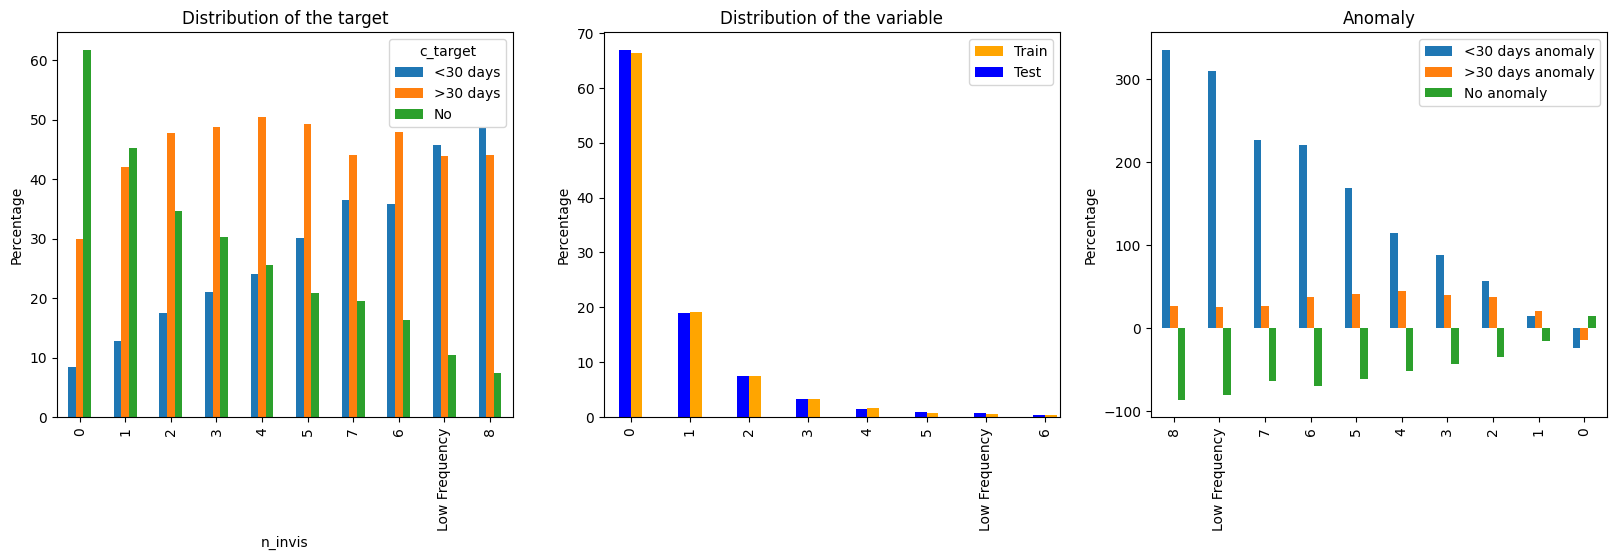

In [221]:
var_report('n_invis', data, hide_low_freq=True)

In [222]:
data['n_invis'] = data['n_invis'].clip(upper=5)
data['n_invis'].value_counts(dropna=False)

0    67627
1    19521
2     7566
3     3411
5     2016
4     1622
Name: n_invis, dtype: int64

##### __6.3 Emvisits__
- __Last bin = 3__

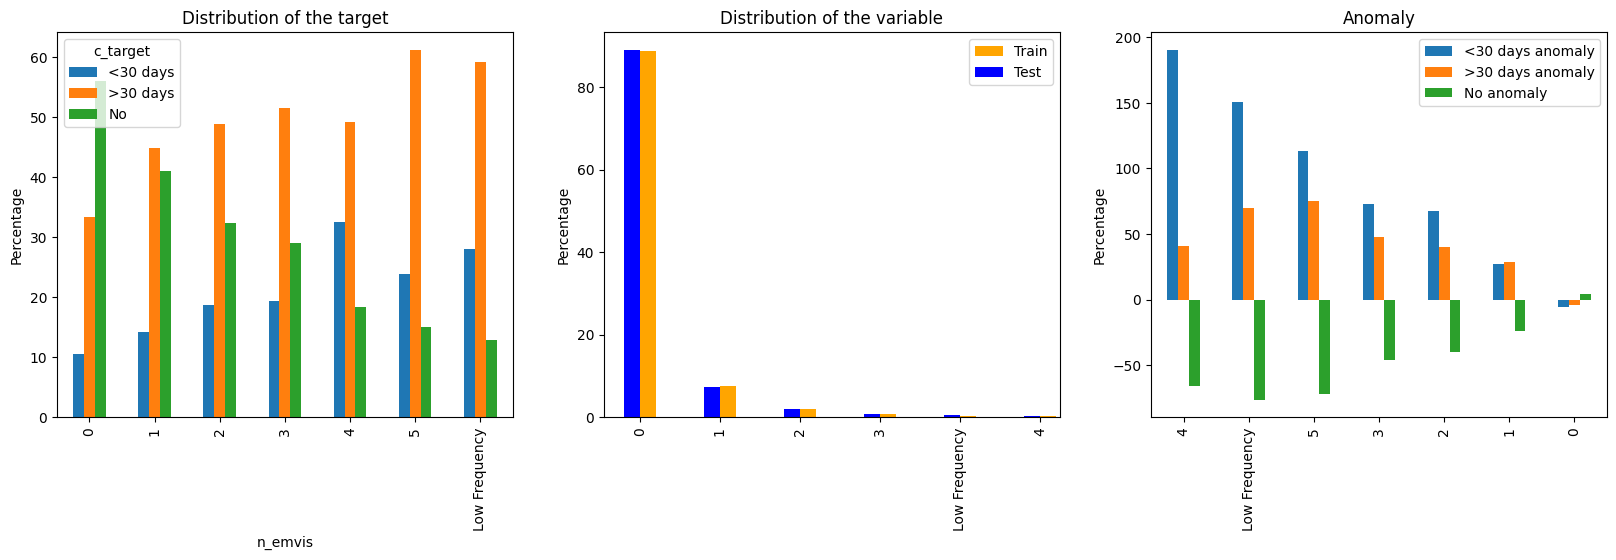

In [223]:
var_report('n_emvis', data, hide_low_freq=True)

In [224]:
data['n_emvis'] = data['n_emvis'].clip(upper=3)
data['n_emvis'].value_counts(dropna=False)

0    90380
1     7677
2     2042
3     1664
Name: n_emvis, dtype: int64

##### __6.4 Total visits__
- __Last bin = 7__

,Counts,Percentage,<30 days,>30 days,No
0,38986,54.73,8.13,27.96,63.91
1,14031,19.70,11.39,39.13,49.48
2,7072,9.93,14.95,43.38,41.67
3,4168,5.85,15.50,47.05,37.45
4,2905,4.08,16.52,47.13,36.35
5,1833,2.57,20.73,50.35,28.91
6,981,1.38,24.97,51.68,23.34
7,561,0.79,25.67,51.87,22.46
8,393,0.55,30.53,54.96,14.50
9,163,0.23,37.42,48.47,14.11


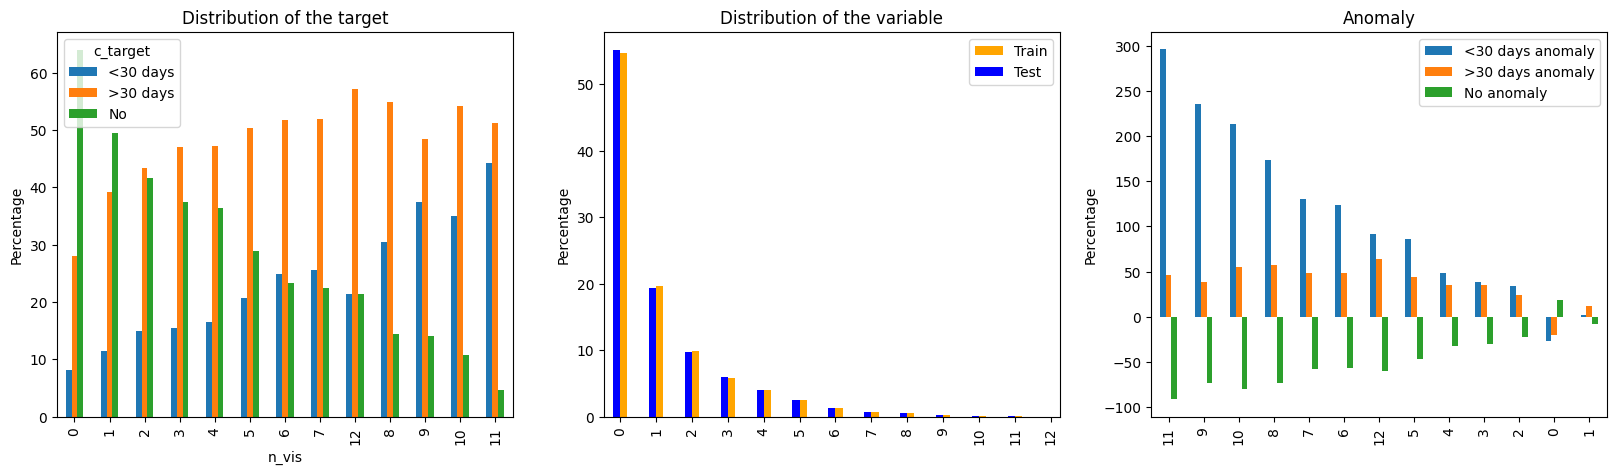

In [225]:
data['n_vis'] = data['n_outvis'] + data['n_invis'] + data['n_emvis']
var_report('n_vis', data)

#### __7. Admission Type__
__Modifications:__
- One hot encoding, keeping the Missing, elective and emergency
<br>

__Relevant Information:__
- Trauma and Newborn are totally irrelevant.
- Missing is very important for the >30days
- Elective for the No anomaly 
- Emergency for the <30days 
__________________________________________

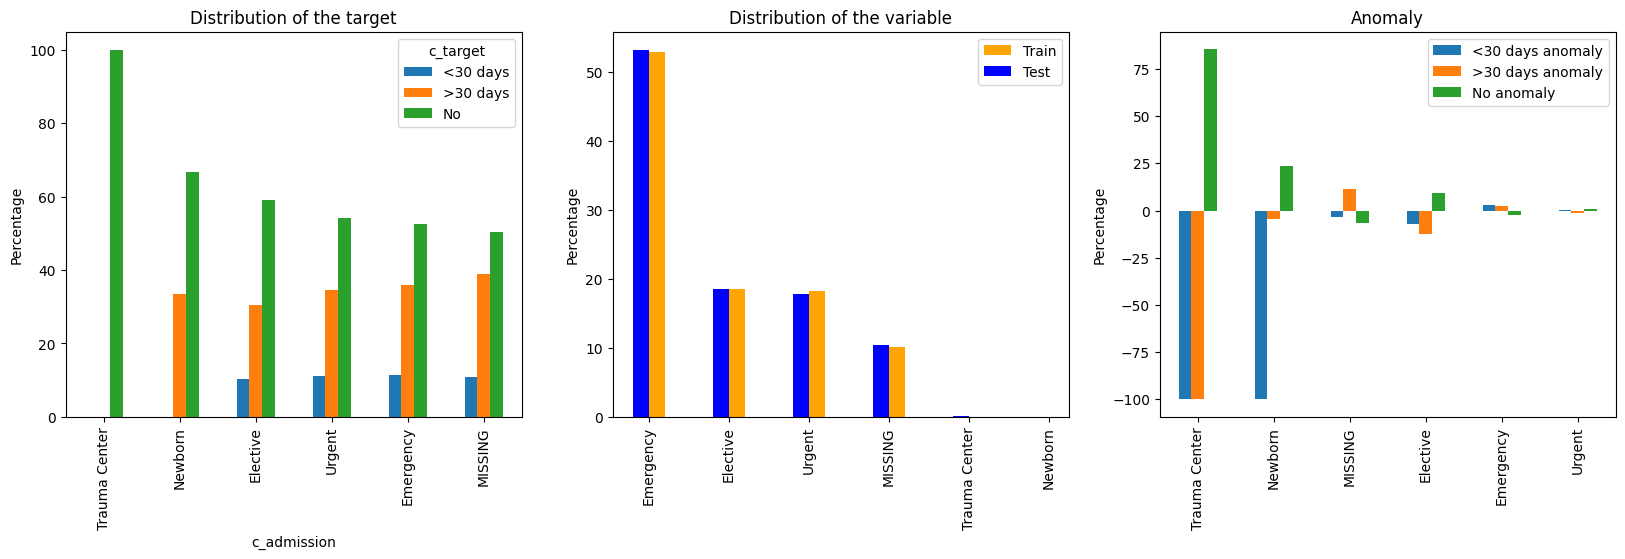

In [227]:
var_report('c_admission', data)

In [230]:
# Group Trauma Center and Newborn into Other
data = one_hot_encode(data, 'c_admission', drop_first=False).drop(['b_admission_Trauma Center', 'b_admission_Newborn', 'b_admission_Urgent'], axis=1)

#### __8. Medical Specialty__
__Modifications:__
- Grouping the low count categories into one category (<150)
- Grouping the hematology/oncology together
- Grouping Surgery-Cardiovascular/Thoracic with Orthopedics-Reconstructive, Low Frequency, ObstetricsandGynecology, Surgery-Neuro, Urology, Orthopedics and Pediatrics, because of similar profile of anomalies
- Grouping Neurology with Pediatrics-Endocrinology, because of similar profile of anomalies
- Group Cardiology with Radiology
- One hot encoding 
<br>

__Relevant Information:__
- Oncology/Hematology, physicalMedicineandRehabilitation, Nephrology, Surgery-Vascular are very important for the <30days anomaly
- A lot of information in general
__________________________________________

,Counts,Percentage,<30 days,>30 days,No
MISSING,34920,49.02,11.59,36.57,51.84
InternalMedicine,10292,14.45,11.15,32.11,56.73
Emergency/Trauma,5319,7.47,11.32,39.35,49.33
Family/GeneralPractice,5217,7.32,11.71,35.46,52.83
Cardiology,3715,5.22,7.94,34.80,57.25
Surgery-General,2144,3.01,11.47,34.19,54.34
Low Frequency,1289,1.81,7.53,29.09,63.38
Nephrology,1136,1.59,15.67,41.20,43.13
Orthopedics,954,1.34,10.06,22.96,66.98
Orthopedics-Reconstructive,867,1.22,7.96,23.99,68.05


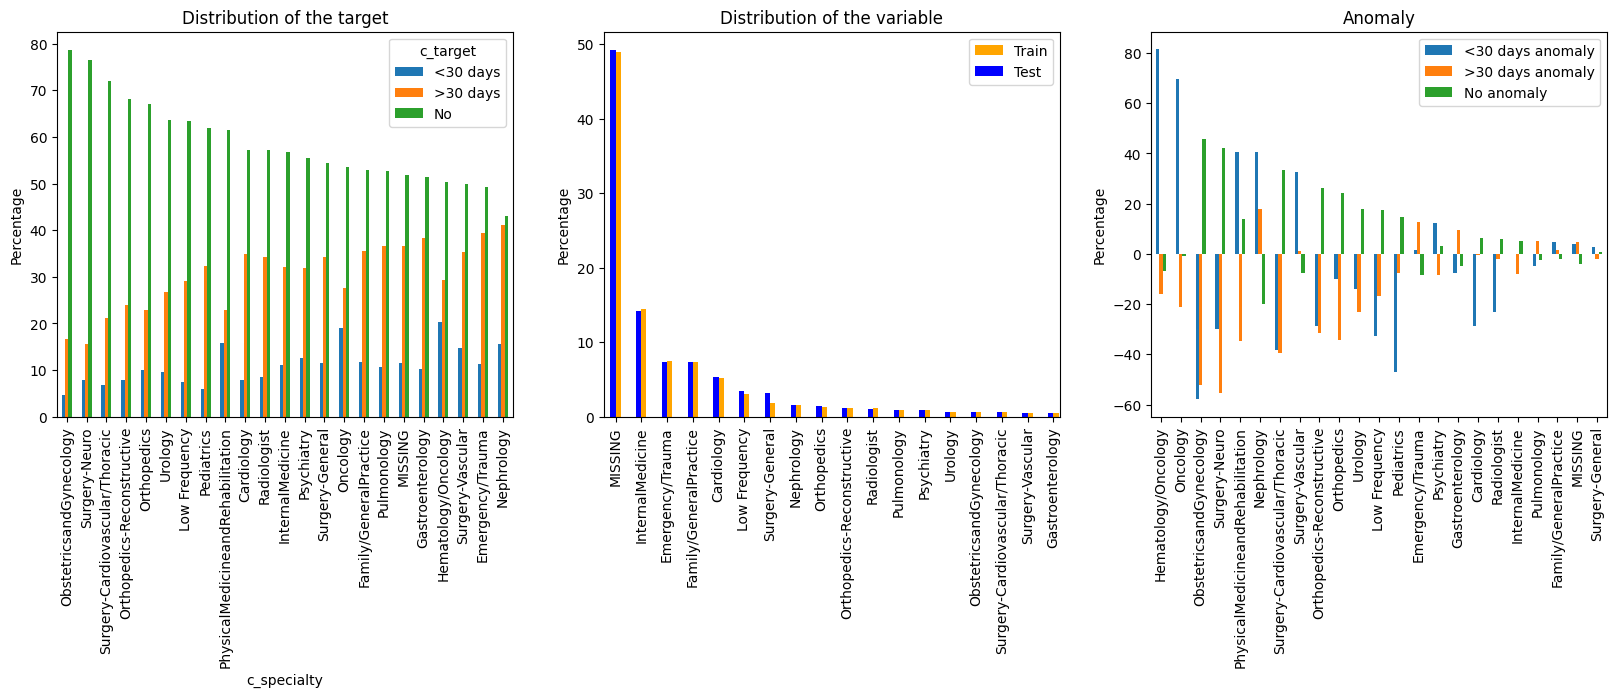

In [246]:
var_report('c_specialty', data, hide_low_freq=True, count_threshold=150)

In [261]:
# - Grouping the low count categories into one category (<150)
low_count = data['c_specialty'].value_counts()[data['c_specialty'].value_counts() < 100].index
data['c_specialty'] = data['c_specialty'].replace(low_count, 'Low Count')

# - Grouping the hematology/oncology together
data['c_specialty'] = data['c_specialty'].replace('Oncology', 'Hematology-Oncology')

# - Grouping Surgery-Cardiovascular/Thoracic with Orthopedics-Reconstructive, Low Frequency, ObstetricsandGynecology, Surgery-Neuro, Urology and Pediatrics, because of similar profile of anomalies
data['c_specialty'] = data['c_specialty'].replace(['Surgery-Cardiovascular/Thoracic', 'Orthopedics-Reconstructive', 'Low Count', 'ObstetricsandGynecology', 'Surgery-Neuro', 'Urology', 'Pediatrics', 'Orthopedics'], 'Other')

# - Group Neurology with Pediatrics-Endocrinology
data['c_specialty'] = data['c_specialty'].replace('Pediatrics-Endocrinology', 'Neurology')

# - Group Cardiology with Radiology
data['c_specialty'] = data['c_specialty'].replace('Radiologist', 'Cardiology')

,Counts,Percentage,<30 days,>30 days,No
MISSING,34920,49.02,11.59,36.57,51.84
InternalMedicine,10292,14.45,11.15,32.11,56.73
Emergency/Trauma,5319,7.47,11.32,39.35,49.33
Family/GeneralPractice,5217,7.32,11.71,35.46,52.83
Other,4767,6.69,8.20,24.50,67.30
Cardiology,4532,6.36,8.05,34.71,57.24
Surgery-General,2144,3.01,11.47,34.19,54.34
Nephrology,1136,1.59,15.67,41.20,43.13
Pulmonology,611,0.86,10.64,36.66,52.70
Psychiatry,598,0.84,12.54,31.94,55.52


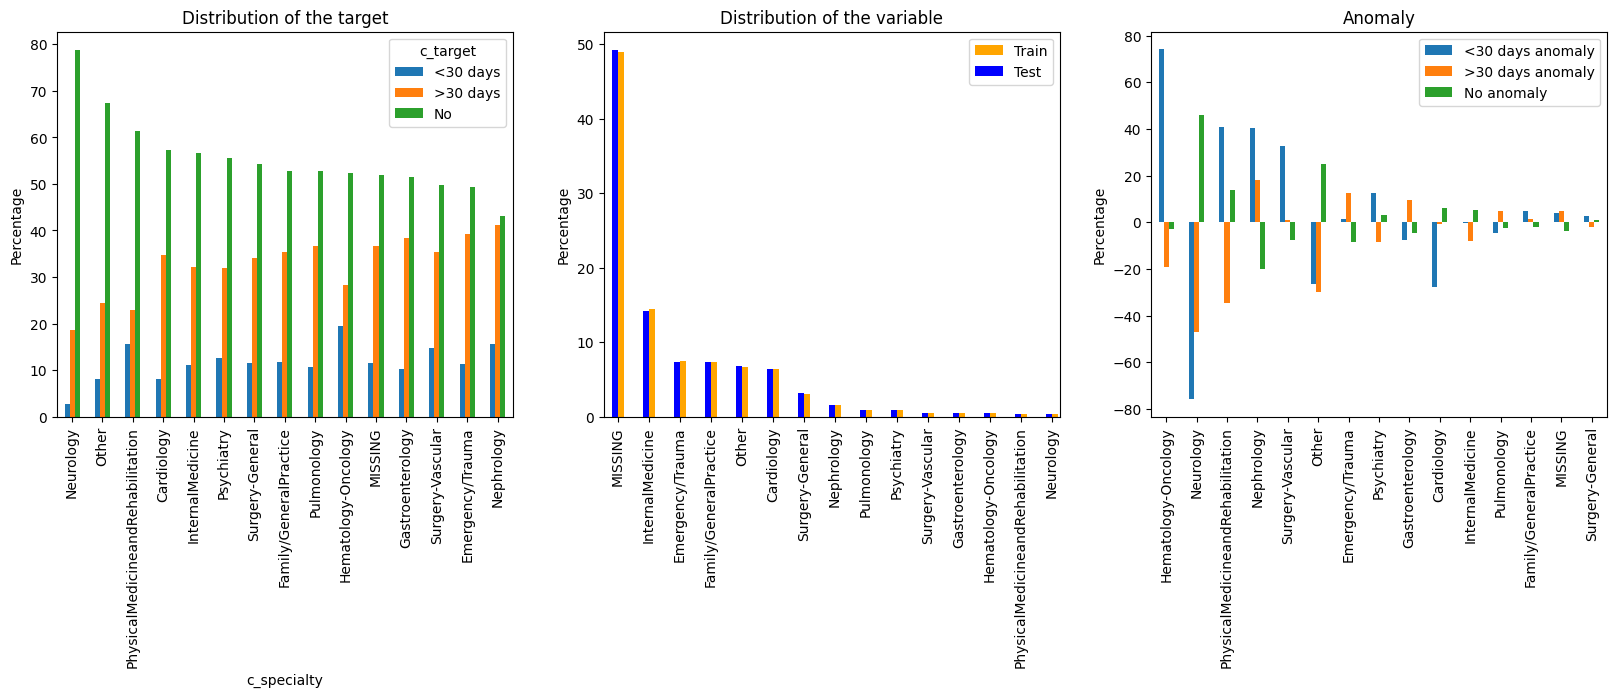

In [262]:
var_report('c_specialty', data)

In [264]:
# One hot encode the specialty
data = one_hot_encode(data, 'c_specialty', drop_first=False)

#### __9. Pulse (BPM)__
__Modifications:__
- Deleting the pulse column
<br>

__Relevant Information:__
- No relevant information 
__________________________________________

In [268]:
data = data.drop('n_pulse', axis=1)

#### __10. Discharge Disposition__
__Modifications:__
- `We will use an imputer to fill the missing values, but we will drop the missing values in the test data`
- Changing the name of the variables to be more intuitive
- Grouping the low frequency (<100) with the Discharged/transferred to another rehab fac including rehab units of a hospital .
- Grouping hospices together
<br>

__Relevant Information:__
- Great information !! 
- For <30days we have: rehab, low freq, inpatient care institution, Discharged/transferred to another short term hospital, Left AMA, Discharged/transferred to SNF, Discharged/transferred to ICF
- For both: Discharged/transferred to home with home health service	
- For No we have: expired, and hospices, as well as discharged/transfered to a long term care hospital
__________________________________________

,Counts,Percentage,<30 days,>30 days,No
Discharged to home,42254,59.32,9.27,35.72,55.01
Discharged/transferred to SNF,9780,13.73,14.62,35.44,49.94
Discharged/transferred to home with home health service,9005,12.64,12.64,41.64,45.72
MISSING,3269,4.59,12.14,29.70,58.15
Discharged/transferred to another short term hospital,1488,2.09,16.53,31.05,52.42
Discharged/transferred to another rehab fac including rehab units of a hospital .,1392,1.95,27.87,25.36,46.77
Expired,1135,1.59,0.00,0.00,100.00
Discharged/transferred to another type of inpatient care institution,822,1.15,20.92,28.35,50.73
Discharged/transferred to ICF,571,0.80,12.43,34.33,53.24
Left AMA,421,0.59,14.73,36.58,48.69


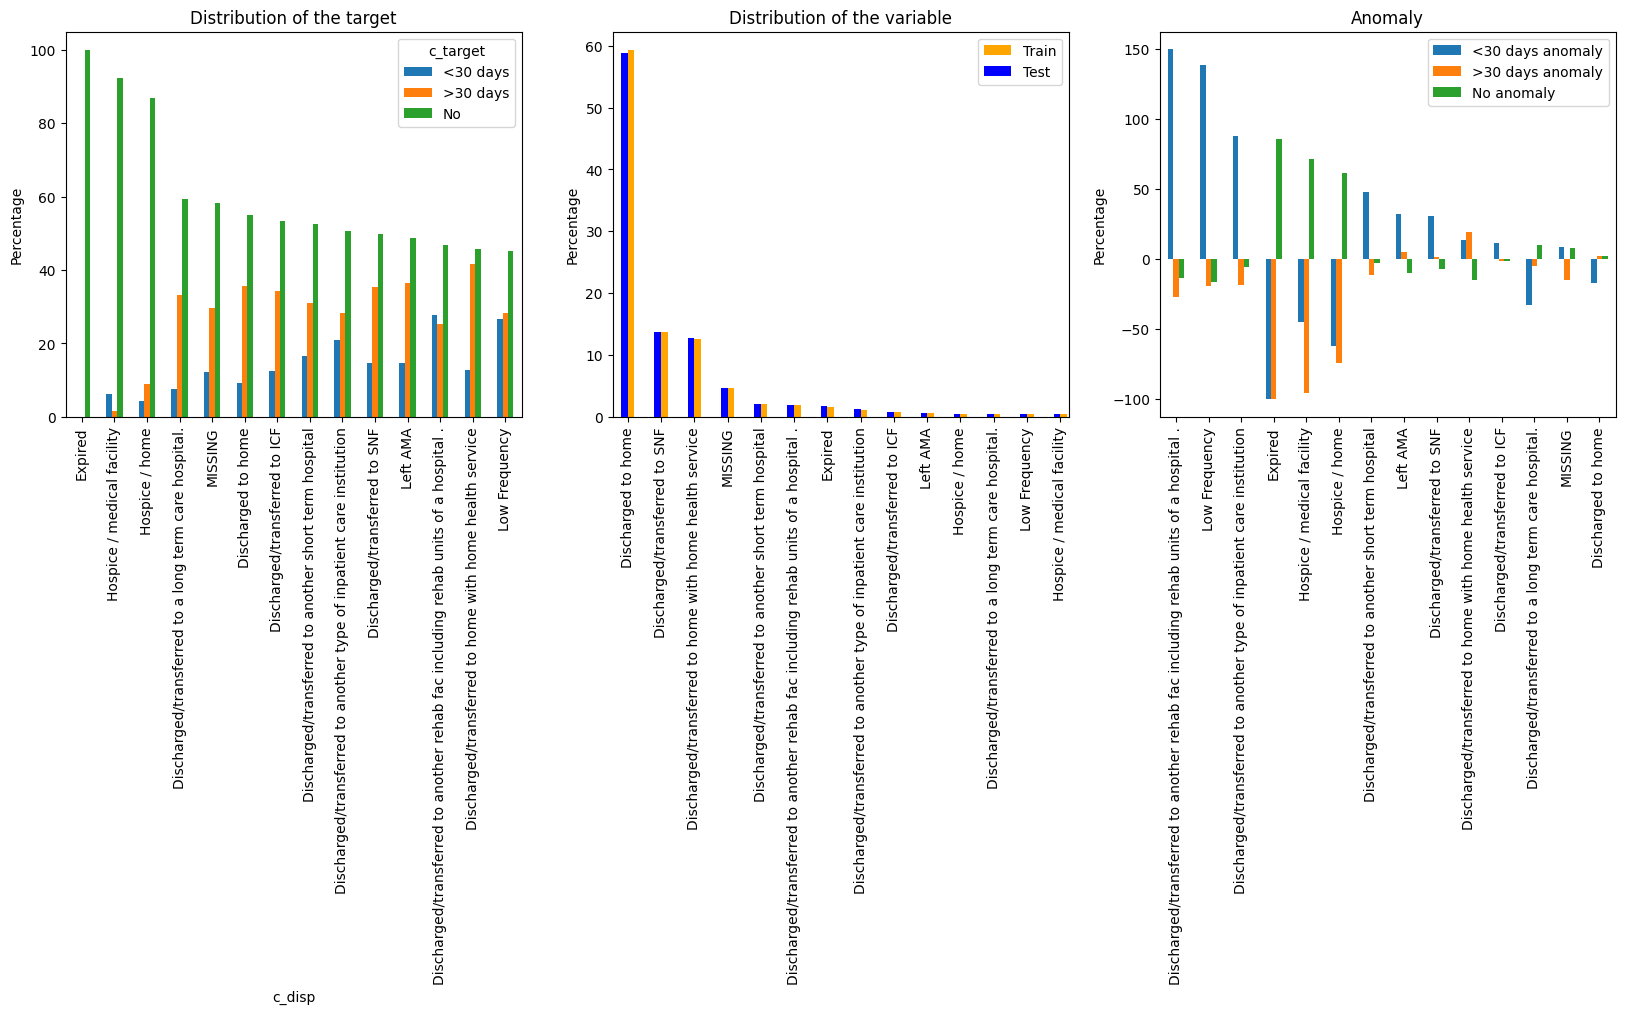

In [270]:
var_report('c_disp', data, hide_low_freq=True, count_threshold=100)

In [282]:
# - Grouping the low frequency (<100) with the Discharged/transferred to another rehab fac including rehab units of a hospital .
low_count = data['c_disp'].value_counts()[data['c_disp'].value_counts() < 100].index.to_list()
to_unite = low_count + ['Discharged/transferred to another rehab fac including rehab units of a hospital .']
data['c_disp'] = data['c_disp'].replace(to_unite, 'High Readmission')

# - Grouping columns that contain word hospice
data['c_disp'] = data['c_disp'].replace(['Hospice / home', 'Hospice / medical facility'], 'Hospice')

# - Grouping Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital	 with high readmission
data['c_disp'] = data['c_disp'].replace('Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital', 'High Readmission')

# - Group Discharged/transferred to home under care of Home IV provider	 with Discharged/transferred to home with home health service	
data['c_disp'] = data['c_disp'].replace('Discharged/transferred to home under care of Home IV provider', 'Discharged/transferred to home with home health service')

,Counts,Percentage,<30 days,>30 days,No
Home,42254,59.32,9.27,35.72,55.01
SNF,9780,13.73,14.62,35.44,49.94
Home Health,9086,12.76,12.63,41.61,45.75
MISSING,3269,4.59,12.14,29.70,58.15
High Readmission,1608,2.26,28.42,25.25,46.33
ST Hospital,1488,2.09,16.53,31.05,52.42
Expired,1135,1.59,0.00,0.00,100.00
Inpatient Care,822,1.15,20.92,28.35,50.73
ICF,571,0.80,12.43,34.33,53.24
Hospice,519,0.73,5.20,5.20,89.60


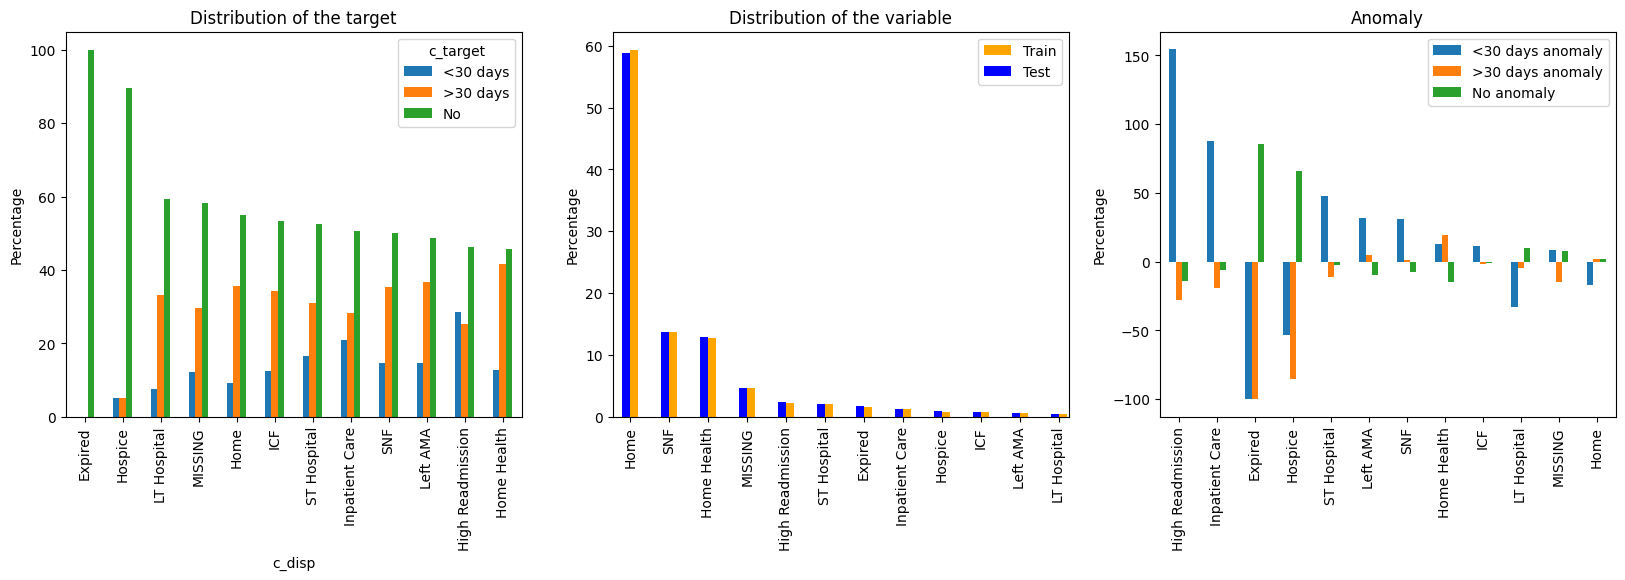

In [290]:
# Change the name of the values inside the column to be more readable
mapper = {
    'Discharged/transferred to another type of inpatient care institution' : 'Inpatient Care',
    'Discharged/transferred to another short term hospital' : 'ST Hospital',
    'Discharged/transferred to SNF' : 'SNF',
    'Discharged/transferred to home with home health service' : 'Home Health',
    'Discharged/transferred to ICF' : 'ICF',
    'Discharged/transferred to a long term care hospital.' : 'LT Hospital',
    'Discharged to home' : 'Home',
}

data['c_disp'] = data['c_disp'].replace(mapper)

var_report('c_disp', data)

#### __11. Admission Source__
__Modifications:__
- `Imputing the missing values with an imputer will be done`
- Grouping the low frequency (<100) with Transfer from another health care facility	and Transfer from a hospital

<br>

__Relevant Information:__
- Some information in HMO Referral and SNF for <30days
- Emergency Room and Missing have good information for >30days
- Transfer from another health care facility and a hospital as well as low frequency are good to predict a No
__________________________________________

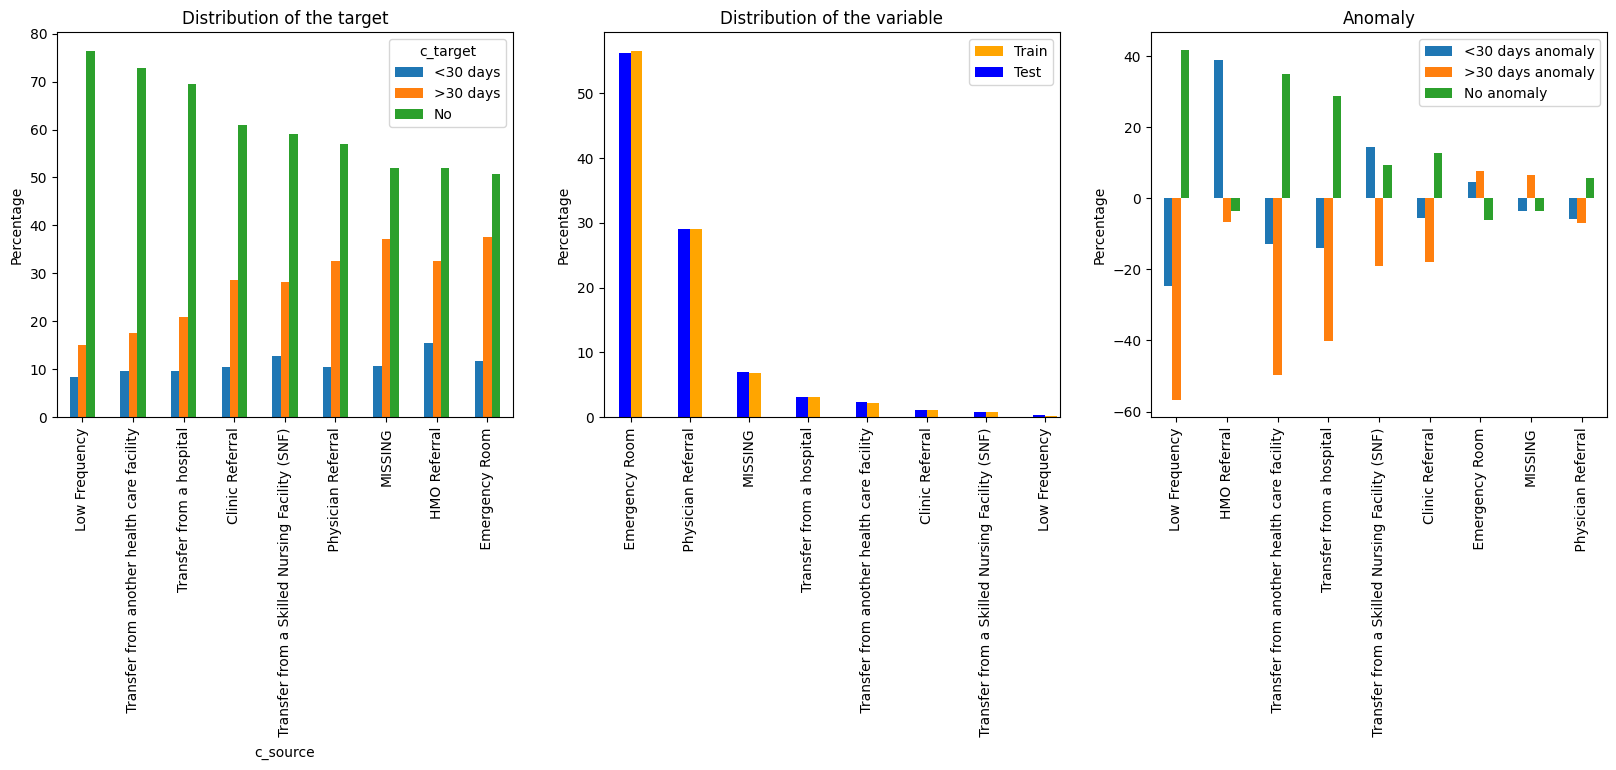

In [292]:
var_report('c_source', data, hide_low_freq=True, count_threshold=100)

In [300]:
# - Grouping the low frequency (<100) with Transfer from another health care facility and Transfer from a hospital
low_count = data['c_source'].value_counts()[data['c_source'].value_counts() < 100].index.to_list()
to_unite = low_count + [' Transfer from another health care facility', 'Transfer from a hospital']
data['c_source'] = data['c_source'].replace(to_unite, 'Very low readmission')

# Adding Not Available to the Very Low Readmission group
data['c_source'] = data['c_source'].replace('Not Available', 'Very low readmission')

#### __12. Length of stay__
__Modifications:__
- None 
<br>

__Relevant Information:__
- Strange relationship with the anomaly, but it is informative, so we will just let it be as it is
__________________________________________

,Counts,Percentage,<30 days,>30 days,No
3,12434,17.46,10.83,34.15,55.03
2,12119,17.01,9.88,34.52,55.61
1,10008,14.05,8.41,31.10,60.49
4,9656,13.56,11.80,36.76,51.44
5,6967,9.78,11.97,36.11,51.92
6,5237,7.35,12.13,37.03,50.85
7,4154,5.83,13.22,35.68,51.11
8,3002,4.21,14.59,35.54,49.87
9,2105,2.96,13.25,37.39,49.36
10,1637,2.30,13.93,35.06,51.01


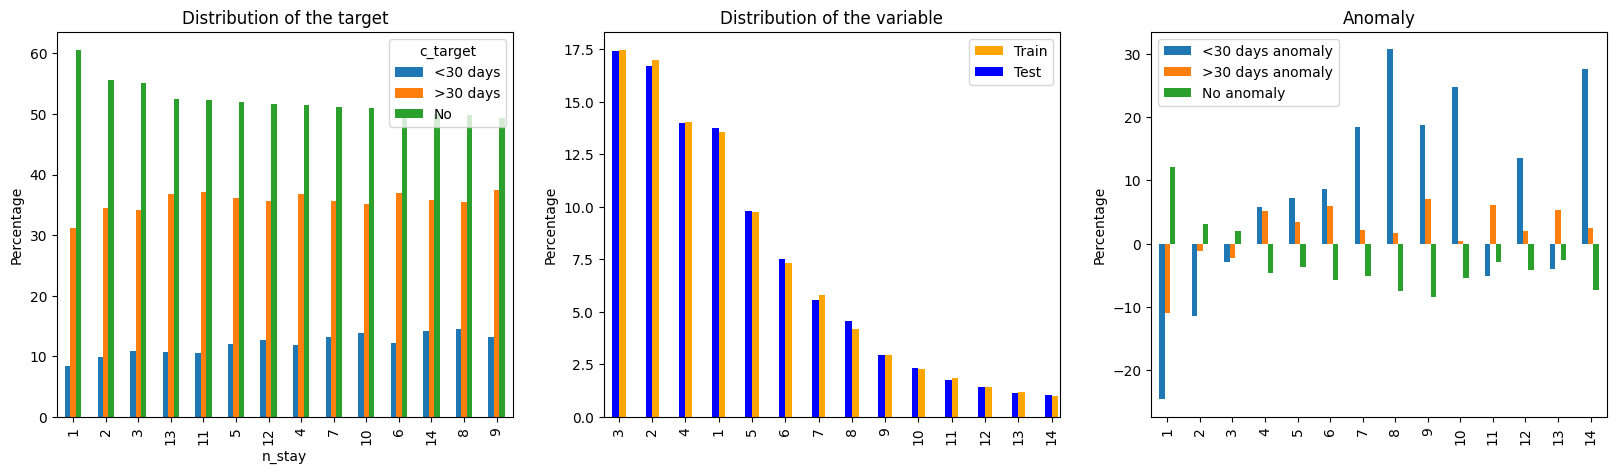

In [307]:
var_report('n_stay', data, order_by_count=True)

#### __13. Number of tests__
__Modifications:__
- Clipping to 80
<br>

__Relevant Information:__
- From 80 onwards the information turns into noise. 
- As the number of tests goes up, the <>30days prevalence goes up, which is good 
__________________________________________

Text(0.5, 1.0, 'Percentage of each target for each number of tests')

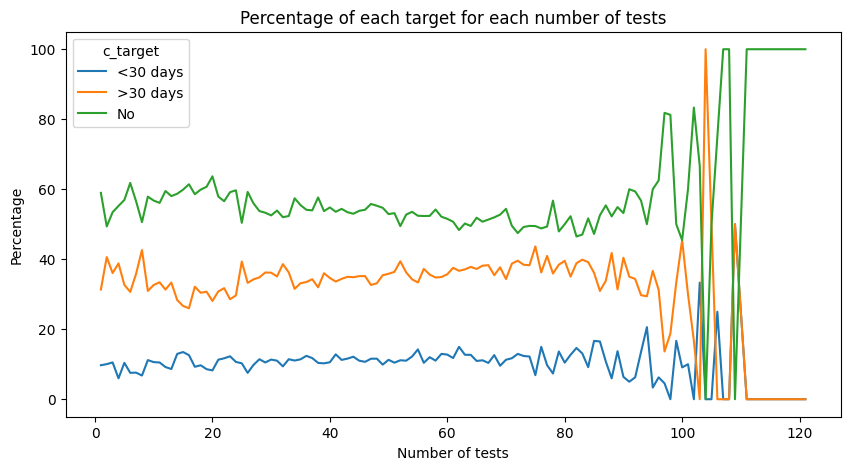

In [313]:
# Create a crosstab
stay_crosstab = pd.crosstab(data['n_tests'], data['c_target'], normalize='index')*100

# Plot the crosstab with a line plot.
fig, ax = plt.subplots(figsize=(10,5))
stay_crosstab.plot.line(ax=ax)
ax.set_xlabel('Number of tests')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of each target for each number of tests')

Text(0.5, 1.0, 'Percentage of each target for each number of tests')

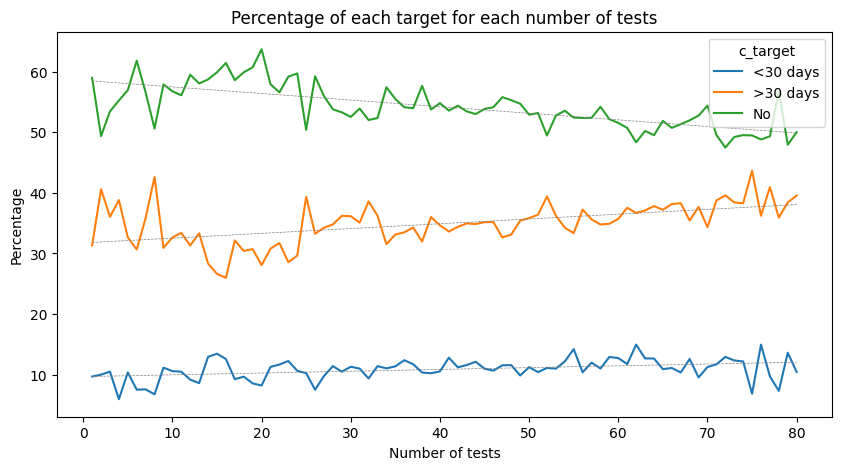

In [319]:
stay_crosstab = stay_crosstab.loc[:80]

# Plot the crosstab with a line plot.
fig, ax = plt.subplots(figsize=(10,5))
stay_crosstab.plot.line(ax=ax)

# Fitting regression lines to the plot
for col in stay_crosstab.columns:
    x = stay_crosstab.index
    y = stay_crosstab[col]
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x + b, color='grey', linestyle='--', linewidth=0.5)
ax.set_xlabel('Number of tests')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of each target for each number of tests')

In [329]:
# Clip to 80
data['n_tests'] = data['n_tests'].clip(upper=80)

#### __14. Number of non lab procedures__
__Modifications:__
- Creating the 1 non lab procedure column
<br>

__Relevant Information:__
- Definetely some correlation with the anomaly, but not very strong.
- LOTS of information for the 1 non lab procedure column
__________________________________________

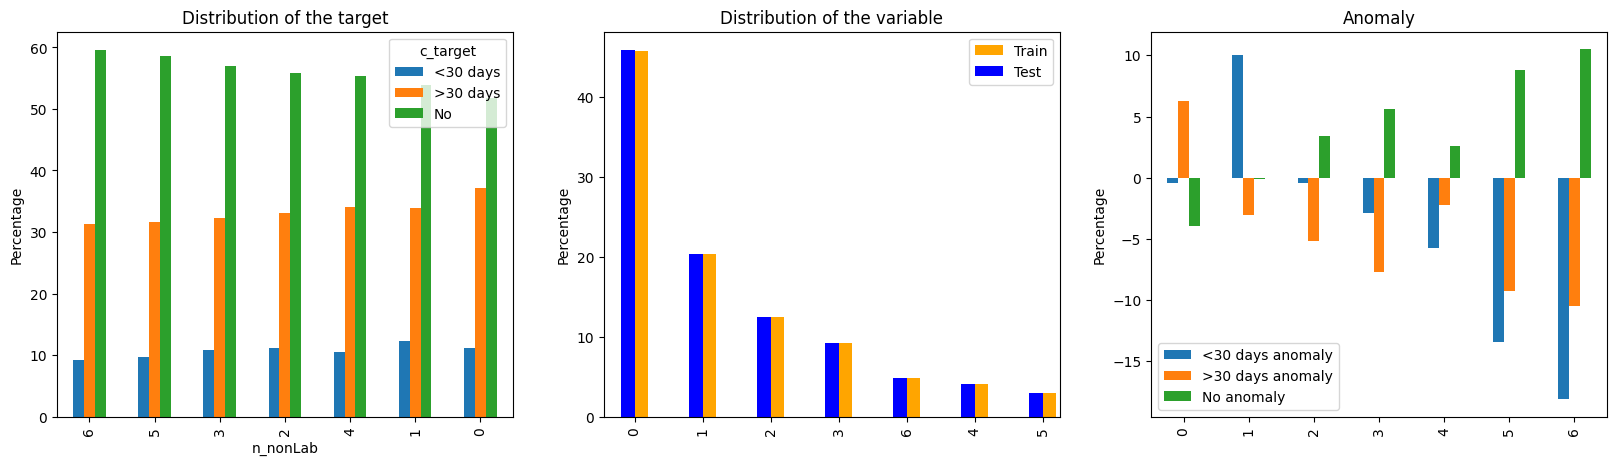

In [331]:
var_report('n_nonLab', data, order_by_count=True)

In [332]:
data['b_1nonLab'] = (data['n_nonLab'] == 1).astype(np.int8)

#### __15. Number of Medications__
__Modifications:__
- Cutting tails, new range: 9-36
<br>

__Relevant Information:__
- Some information here. 
__________________________________________

,Counts,Percentage,<30 days,>30 days,No
9,14463,20.30,8.56,29.74,61.70
13,4315,6.06,10.87,36.41,52.72
12,4171,5.86,11.22,34.96,53.82
15,4065,5.71,12.00,36.24,51.76
11,4051,5.69,10.57,35.30,54.13
14,4029,5.66,10.62,36.49,52.89
16,3786,5.31,11.60,38.64,49.76
10,3686,5.17,10.04,33.80,56.16
17,3455,4.85,12.42,36.27,51.32
18,3172,4.45,12.45,38.75,48.80


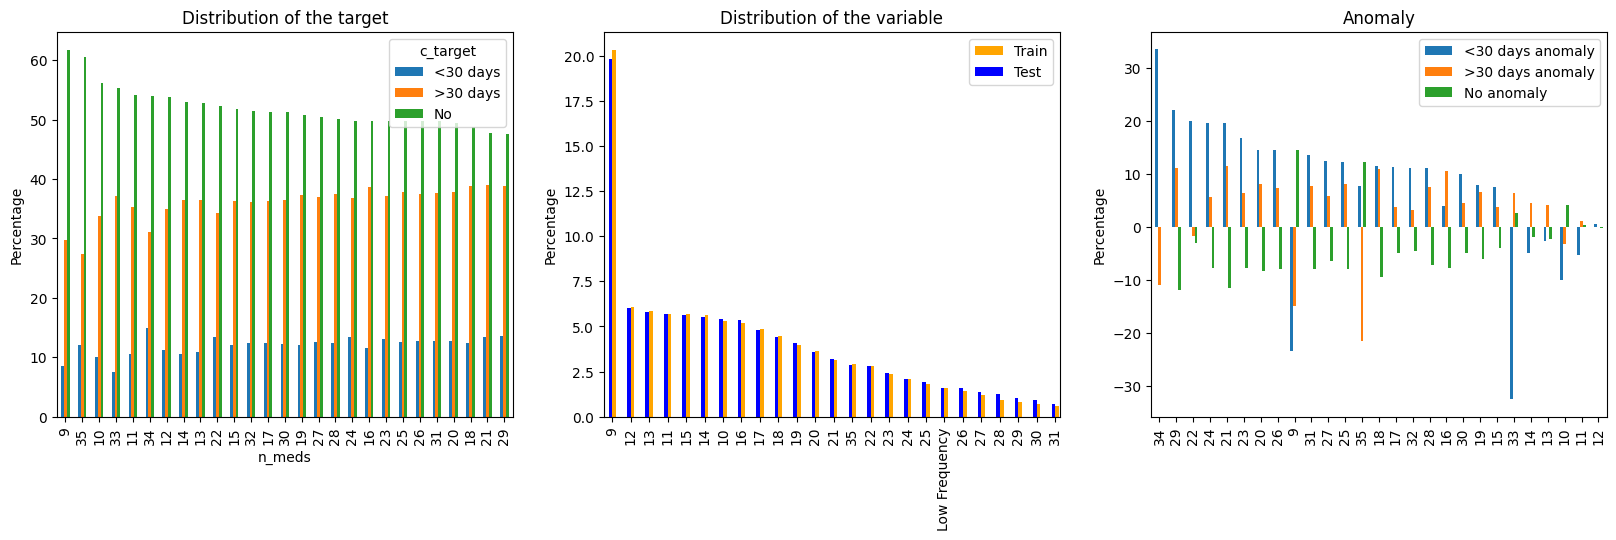

In [364]:
var_report('n_meds', data, hide_low_freq=True, count_threshold=200)

Text(0, 0.5, 'Count')

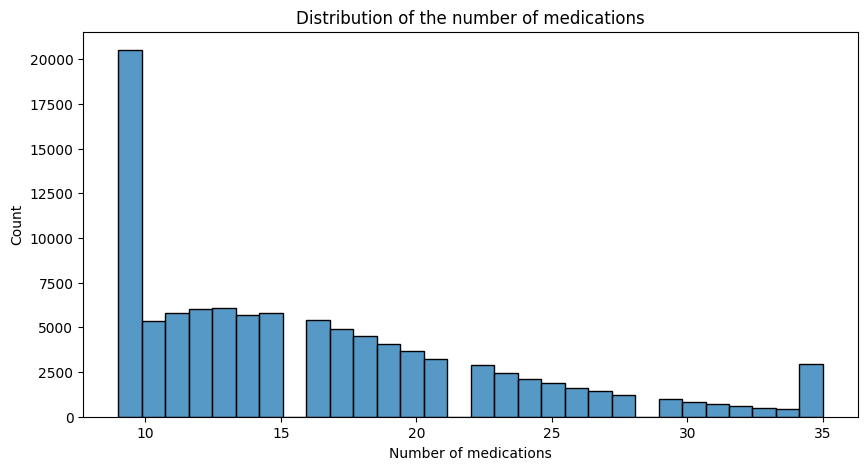

In [363]:
# Plot the distribution of the number of non lab procedures
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data['n_meds'], ax=ax, bins=30)
ax.set_title('Distribution of the number of medications')
ax.set_xlabel('Number of medications')
ax.set_ylabel('Count')

In [362]:
# Cut the tails 9-35
data['n_meds'] = data['n_meds'].clip(lower=9, upper=35)

#### __16. Diagnosis (1,2,3)__
__Modifications:__

<br>

__Relevant Information:__

__________________________________________

#### __17. Number of Diagnosis__
__Modifications:__
- Clipping to 9 
<br>

__Relevant Information:__
- Good correlation between the number of diagnosis and the readmission rate until 9, which is why we clipped it there. 9 has a higher readmission rate than average, so it contains information, especially because it has a high count
__________________________________________

,count,target_mean,percentage,distance (%)
n_diag,,,,
9,34668,0.124,48.67,11.40
5,7920,0.089,11.12,-20.04
8,7375,0.117,10.35,5.12
7,7264,0.109,10.20,-2.07
6,7134,0.103,10.02,-7.46
4,3902,0.081,5.48,-27.23
3,1994,0.077,2.80,-30.82
2,727,0.059,1.02,-46.99
1,164,0.049,0.23,-55.98


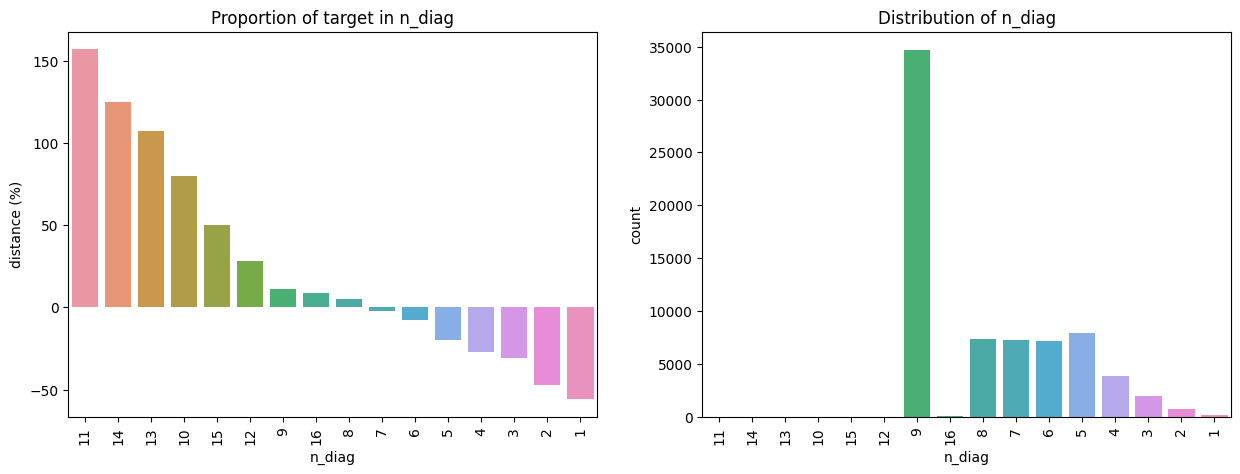

In [ ]:
var_report('n_diag', data)

In [ ]:
# Clip to 9 
data['n_diag'] = data['n_diag'].clip(upper=9)

#### __18. Glucose Tests__
__Modifications:__
- Droping the a1c test column and modifying the glucose test column
<br>

__Relevant Information:__
- No relevant information, especially for the a1c test - even the absence of a test doesn't seem to be relevant 
- A little bit of relevant information for the glucose test, but not much
__________________________________________

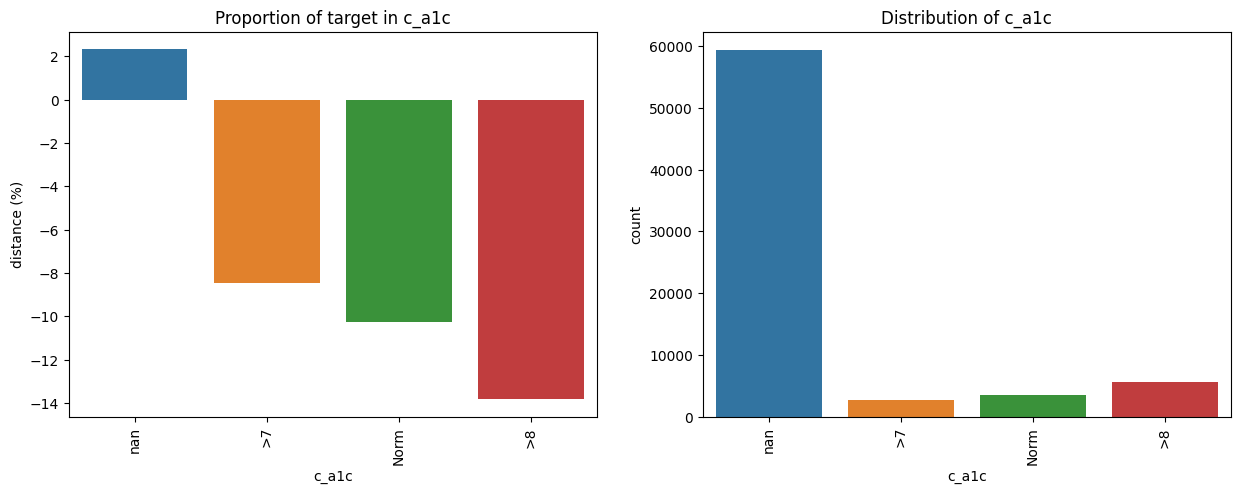

In [ ]:
var_report('c_a1c', data)
data = data.drop('c_a1c', axis=1)

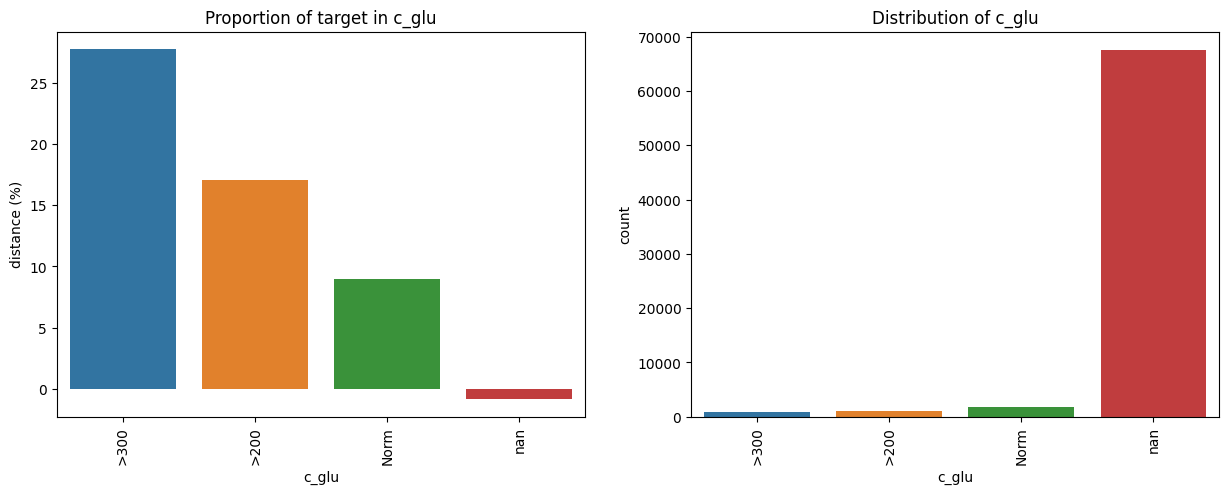

In [ ]:
var_report('c_glu', data)

In [ ]:
# One hot encode the glucose test result
data = one_hot_encode(data, 'c_glu', drop_first=False)

#### __19. Change in Meds__
__Modifications:__
- NONE
<br>

__Relevant Information:__
- Some relevant information for the model. The change in meds seems to be relevant
- No nan values
__________________________________________

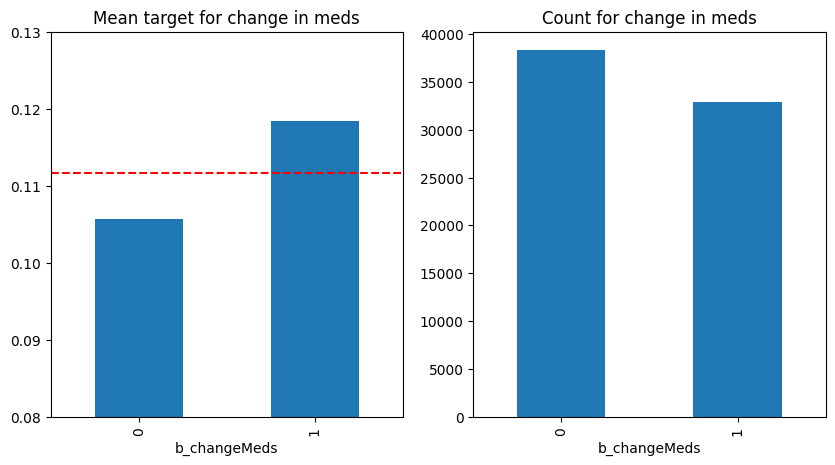

In [ ]:
# Plot the mean target for the binary change in meds variable and on the side the count
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
data.groupby('b_changeMeds')['b_target'].mean().plot.bar(ax=ax[0])
data.groupby('b_changeMeds')['b_target'].count().plot.bar(ax=ax[1])
# Plot an axhline for the mean target
ax[0].axhline(data['b_target'].mean(), color='red', linestyle='--')
ax[0].set_title('Mean target for change in meds')
ax[1].set_title('Count for change in meds')
ax[0].set_ylim(0.08, 0.13)
plt.show()

#### __20. Diabetes Meds__
__Modifications:__
- NONE
<br>

__Relevant Information:__
- Same thing as the change in meds
__________________________________________

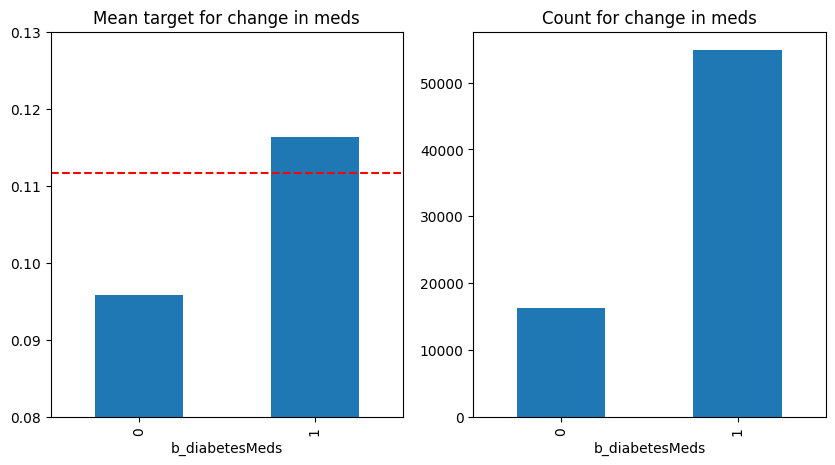

In [ ]:
# Plot the mean target for the binary change in meds variable and on the side the count
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
data.groupby('b_diabetesMeds')['b_target'].mean().plot.bar(ax=ax[0])
data.groupby('b_diabetesMeds')['b_target'].count().plot.bar(ax=ax[1])
# Plot an axhline for the mean target
ax[0].axhline(data['b_target'].mean(), color='red', linestyle='--')
ax[0].set_title('Mean target for change in meds')
ax[1].set_title('Count for change in meds')
ax[0].set_ylim(0.08, 0.13)
plt.show()

#### __21. Medications__
__Modifications:__
- Extracting the array of medications and creating many binary columns
- Keeping only repaglinide and insulin
<br>

__Relevant Information:__
- Only repaglinide and insulin seem to be relevant for the model
__________________________________________

In [ ]:
# Transforming the medication list into many dummy variables
meds = data['c_medication'].str.get_dummies(sep=',')

# Remove any symbols from the column names
to_remove = ['[', ']', "'", ' ']
for symbol in to_remove:
    meds.columns = meds.columns.str.replace(re.escape(symbol), '', regex=True)

unique_cols = meds.columns.unique()
new_meds = pd.DataFrame(columns=unique_cols)
for col in unique_cols:
    if type(meds[col]) == pd.Series:
        new_meds[col] = meds[col]
    else:
        new_meds[col] = meds[col].max(axis=1)
meds = new_meds

# Lets delete combinations of drugs
for col in meds.columns.unique():
    if '-' in col:
        meds.drop(col, axis=1, inplace=True)

# Rename the last column to avoid confusion
meds.rename(columns={'' : 'noMeds'}, inplace=True)

# Add a b_ prefix to the column names
meds.columns = ['b_' + col for col in meds.columns]

data = pd.concat([data,meds], axis=1)
# Deleting the medication column
data.drop('c_medication', axis=1, inplace=True)

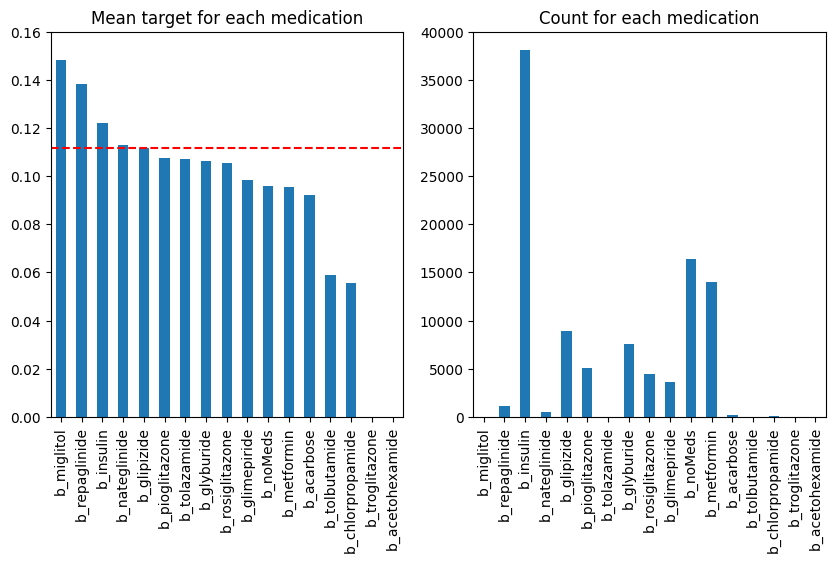

In [ ]:
meds_exploration = data[meds.columns.tolist()+['b_target']]

group = meds_exploration.groupby('b_target').sum().T
group['total'] = group.sum(axis=1)
group['mean'] = group[1] / group['total']
group.sort_values(by='mean', ascending=False, inplace=True) 

# Plot the mean target for each medication and on the side the count
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
group['mean'].plot.bar(ax=ax[0])
group['total'].plot.bar(ax=ax[1])
# Plot an axhline for the mean target
ax[0].axhline(data['b_target'].mean(), color='red', linestyle='--')
ax[0].set_title('Mean target for each medication')
ax[1].set_title('Count for each medication')
ax[0].set_ylim(0, 0.16)
plt.show()



In [ ]:
data = data.drop(list(set(meds.columns)-set(['b_insulin', 'b_repaglinide'])), axis=1)